In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn import cross_validation 
sns.set()
%matplotlib inline

In [2]:
column_names="""short_comment, dbio_verid, dbio_lastchanged, dbio_created_by, score_value, long_comment,  ccare_required, dbio_rowid, dbio_created_on, unique_id, status, status_code, delivery_date, delivery_date_tz,  ship_date_tz, ship_date, eta_date, eta_date_tz, overall_score, packaging_score, itemcond_score, uidesign_score, received_on, received_on_tz"""
column_names = re.split('\W+',column_names)
pd.options.display.max_columns= len(column_names) + 10

In [3]:
feedback = pd.read_csv('feedback_data/feedback.csv')
feedback.columns = column_names

In [4]:
sentdf = pd.read_csv('feedback_data/sentiment_graded.csv')

In [5]:
feedback.long_comment = feedback.long_comment.str.lower()
feedback.long_comment = feedback.long_comment.replace({'\n':' '},regex=True)
sentdf.long_comment = sentdf.long_comment.replace({'\n':' '},regex=True)

In [6]:
# lots of overlap when people just say 'good' or 'good job' or whatever so trying to avoid for join
sentdf.drop_duplicates('long_comment', inplace=True)

In [7]:
sentdf.shape
#should be (1501,2)

(1501, 2)

In [8]:
df = feedback
df = pd.merge(feedback, sentdf, on='long_comment', how='left')
# clear feedback if needed, just memory issue
feedback = None

###Columns with no values:
* dbio_created_by
* score_value

drop both those columns

```
# for x in range(df.shape[1]):
#     print('column name: '+ df.columns[x] )
#     print(len(df[df.iloc[:,x].notnull()]))
#     print('\n')
```

####other notes:
* tracking number included in unique_id
* no idea what difference between 'delivered' and 'received' for those two columns, just going to use delivered



In [9]:
df.drop(['dbio_created_by','score_value'],inplace=True,axis=1)
df.shape
df.columns

#should be 530793,23 after dropping columns but before adding of additional features

Index(['short_comment', 'dbio_verid', 'dbio_lastchanged', 'long_comment',
       'ccare_required', 'dbio_rowid', 'dbio_created_on', 'unique_id',
       'status', 'status_code', 'delivery_date', 'delivery_date_tz',
       'ship_date_tz', 'ship_date', 'eta_date', 'eta_date_tz', 'overall_score',
       'packaging_score', 'itemcond_score', 'uidesign_score', 'received_on',
       'received_on_tz', 'sentiment'],
      dtype='object')

In [10]:
#len of long_comment
df['length_comment'] = df[df.long_comment.notnull()].long_comment.map(lambda x: len(x))

In [11]:
# grab the fedex shipping type from tracking number, maybe indicitive of customer
df['shipping_type'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[2])
df['tracking_numbers'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[1])

# join the following columns, not using inplace since I was seeing what they were previously

df = df.join(pd.get_dummies(df.shipping_type))
df = df.join(pd.get_dummies(df.short_comment))
# status is not helpful since too much peripheral
# df = df.join(pd.get_dummies(df.status))

not sure what to do with first number from unique_id
is somewhat close to ship date but not exact
example:
    
        20150210200600  
        2015|02|10|20|06|00
        | Y |M | D| H| M| S
    
        
and ship date was same day but different time

``df['timeunknown'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[0])``
``timeunknown=pd.get_dummies(df.timeunknown)``

In [12]:
df.head(3)

short_comment  dbio_verid                  dbio_lastchanged  \
0  Not yet delivered           0  2015-04-14 08:24:10.726032+00:00   
1                NaN           0  2015-04-12 09:38:32.626805+00:00   
2                NaN           0  2015-05-08 04:28:02.062066+00:00   

  long_comment  ccare_required  dbio_rowid                   dbio_created_on  \
0          NaN             NaN     1094225  2015-04-14 08:24:10.726032+00:00   
1          NaN             NaN     1089601  2015-04-12 09:38:32.626805+00:00   
2          NaN               1     1173023  2015-05-08 04:28:02.062066+00:00   

  unique_id         status status_code              delivery_date  \
0       NaN      Delivered   DELIVERED  2015-04-13 11:11:00+00:00   
1       NaN  Just Shipped!         NaN                        NaN   
2       NaN     In-Transit           X                        NaN   

  delivery_date_tz ship_date_tz                         ship_date  \
0              UTC          UTC         2015-04-08 14:19:22+00:00   
1              NaN          UTC  2015-04-12 02:39:01.826000+00:00   
2              NaN          UTC         2015-05-03 00:00:00+00:00   

                    eta_date eta_date_tz  overall_score  packaging_score  \
0                        NaN         NaN            NaN              NaN   
1  2015-04-16 00:00:00+00:00         UTC            NaN              NaN   
2  2015-05-08 00:00:00+00:00         UTC            NaN              NaN   

   itemcond_score  uidesign_score received_on received_on_tz  sentiment  \
0             NaN             NaN         NaN            NaN        NaN   
1             NaN             NaN         NaN            NaN        NaN   
2             NaN             NaN         NaN            NaN        NaN   

   length_comment shipping_type tracking_numbers  FDEG  FX  FXSP  \
0             NaN           NaN              NaN     0   0     0   
1             NaN           NaN              NaN     0   0     0   
2             NaN           NaN              NaN     0   0     0   

   Not yet delivered  early  late  ontime  
0                  1      0     0       0  
1                  0      0     0       0  
2                  0      0     0       0

In [13]:
df.columns
df.drop(u'tracking_numbers',inplace=True, axis=1)

In [14]:
# change things to datetime format for usability
df.delivery_date = pd.to_datetime(df.delivery_date)
df.ship_date = pd.to_datetime(df.ship_date)
df.eta_date = pd.to_datetime(df.eta_date)
# df.sort('ship_date')

In [15]:
print('# of rows with sentiment score of each:\n',df.sentiment.value_counts())

print('\n # of rows with ccare_required count:\n', df.ccare_required.value_counts())

#thought I could do something between ccare_required >= 1 and sentiment == 1

# of rows with sentiment score of each:
 0    2982
1     722
dtype: int64

 # of rows with ccare_required count:
 1     227825
2      11549
3       1033
4        139
5         36
6         10
7          6
10         5
8          4
20         1
16         1
13         1
12         1
11         1
9          1
dtype: int64


###Looking at Trends:
* what effect does missing the eta delivery date (from actual delivery date) have on overall score or sentiment? (if i get around to it)
* predicting overall_score from other features (no plan on doing much feature selection or model selection/blending)
 _____
###small interesting notes:
* big discrepency between customer and carrier information it seems?  (i.e. if short_comment=='Not yet delivered'): status can say delivered 
> df[(df.short_comment=='Not yet delivered') & (df.status =='Delivered')] 

* status feature values don't make sense

* Alot of the data just very inconsistent if it was presummably pulled from some database, probably would be useful to have "standardized" normalization. 

* eta_date seem's like it may be highly inaccurate (i.e. order's with delivery errors of 100+ days)

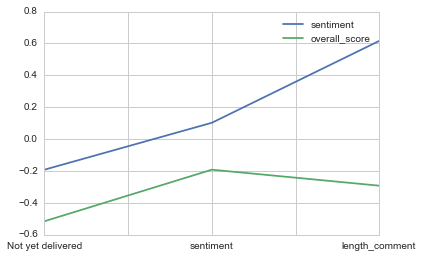

In [16]:
sns.set_style("whitegrid")
df[['overall_score','Not yet delivered', 'sentiment','length_comment']].corr().sentiment.drop('sentiment').plot()
df[['overall_score','Not yet delivered', 'sentiment','length_comment']].corr().overall_score.drop('overall_score').plot()
plt.legend()

In [17]:
df[['overall_score','ccare_required','Not yet delivered', 'sentiment','length_comment']].corr()

overall_score  ccare_required  Not yet delivered  \
overall_score           1.000000       -0.085235          -0.514996   
ccare_required         -0.085235        1.000000           0.028230   
Not yet delivered      -0.514996        0.028230           1.000000   
sentiment              -0.191546        0.097055           0.102684   
length_comment         -0.291937        0.031889          -0.007956   

                   sentiment  length_comment  
overall_score      -0.191546       -0.291937  
ccare_required      0.097055        0.031889  
Not yet delivered   0.102684       -0.007956  
sentiment           1.000000        0.616227  
length_comment      0.616227        1.000000

In [18]:
df.overall_score.value_counts()

5    119014
1     17417
4     16680
3      8375
2      4479
0        14
dtype: int64

Going off of above, best guess to create predictive model with minimal features (not having to do feature selection or "real" data imputation or worrying about various other things).  Simple classification model and simple CV score with no real feature engineering or model validation since the actual "features" are most likely meaningless (i.e. can't base an overall_score on a long_comment score which are most likely left a the same time).

Also from what I can figure out, there's nothing in the data to base a model that would 'flag' a customer or order before it has shipped and customer filled out feedback.  There's no discernabile feature that would relate to a specific customer and nothing that shows information about the order before it has already arrived or is late (ccare_required seem's like it is most likely used once someone's package may already be late or shipped).   Unsure what "whether the customer has clicked the customer care button" would entail since it is probably directly through the narvar web app.

In [19]:
scores=[]
# confusion matrix (could use scikit one instead)
cf=np.zeros((6,6),dtype=int)
# 5 fold cross validation. do manually so we can get the confusion matrix (not cross_val_score)
for i in range(5):
    x_train,x_test,y_train,y_test = cross_validation.train_test_split(df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['Not yet delivered', 'length_comment','sentiment']],df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['overall_score']], test_size=0.2)
    rfc1 = RandomForestClassifier(n_estimators=1000)
    rfc1.fit(x_train,np.ravel(y_train))
    y_tilde=rfc1.predict(x_test)
    y_test=np.ravel(y_test)
    correct = (y_test==y_tilde).mean()
    scores.append(correct)
    for x,y in zip(y_test,y_tilde):
        cf[x,y]+=1
# print cf
print("accuracy: %0.2f (+/- %0.2f)" % (np.array(scores).mean(), np.array(scores).std() * 2))
# might get an er

accuracy: 0.92 (+/- 0.03)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e3034e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11688b3c8>]], dtype=object)

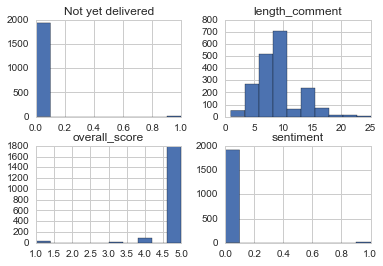

In [20]:
df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['overall_score','Not yet delivered', 'length_comment','sentiment']].hist()

- above shows large class imbalance which needs to be dealt with in model (overall_score), use class_weight on random forest or could go in more thorough process with sample selection later

In [21]:
#dropping some more things at this point to make fillna and dropna work better
df = df.drop(['eta_date_tz','received_on','received_on_tz','shipping_type','unique_id','short_comment','long_comment','delivery_date_tz','ship_date_tz','packaging_score','itemcond_score','uidesign_score','status_code'],axis=1)
# fill in some missing data, questionable on how much this alters
df = df.fillna(method='pad').dropna(axis=0)

In [22]:
# plt.figure(figsize=(8,8))
# df.corr().overall_score.drop('overall_score').plot()
# plt.title('correlation of overall_score w various columns and filled in values')

####fixing dates:
* dates are messed up which results in subtracting not working correctly 
* no idea how accurate hours are or if they are usable for various reasons so just going to base it on day

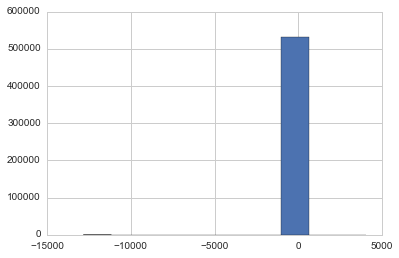

In [24]:
df.drop(df[df.eta_date.str.contains("20")==False].index,axis=0,inplace=True)
df['etaerror'] = pd.to_datetime(df.delivery_date) - pd.to_datetime(df.eta_date)

df['etadays'] = df.etaerror.dt.days
df['etadays'].hist()

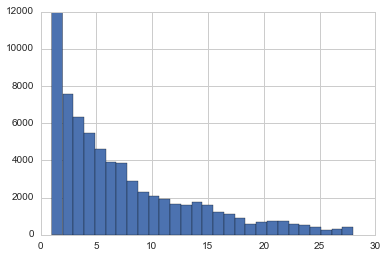

In [26]:
days_mask=((df['etadays']>0) & (df['etadays']<=28))
df = df[days_mask]
df['etadays'].hist(bins=28)
# df['delivery_date']

create model with with 5 fold cv to look at confusion matrix and see if simple rf classifier is very useful:

accuracy: 0.51 (+/- 0.01)


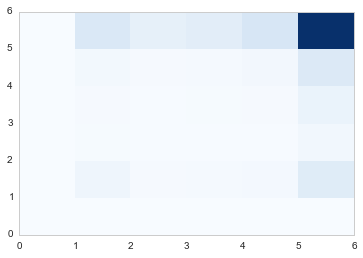

In [30]:
scores=[]
# confusion matrix (could use scikit one instead)
cf=np.zeros((6,6),dtype=int)
all_x = df.drop(["dbio_rowid","overall_score","status","etaerror", "dbio_lastchanged","dbio_created_on","delivery_date","ship_date","eta_date"],axis=1)
# 5 fold cross validation. do manually so we can get the confusion matrix (not cross_val_score)
for i in range(5):
    x_train,x_test,y_train,y_test = cross_validation.train_test_split(all_x, df.overall_score, test_size=0.4)
    rfc = RandomForestClassifier(n_estimators=1000,n_jobs=-1, class_weight="auto")
    rfc.fit(x_train,np.ravel(y_train))
    y_tilde=rfc.predict(x_test)
    y_test=np.ravel(y_test)
    correct = (y_test==y_tilde).mean()
    scores.append(correct)
    for x,y in zip(y_test,y_tilde):
        cf[x,y]+=1
# print cf
plt.pcolor(cf, cmap=plt.cm.Blues)
print("accuracy: %0.2f (+/- %0.2f)" % (np.array(scores).mean(), np.array(scores).std() * 2))
# might get an er

[[    0     0     0     0     0     6]
 [    0  3064   954  1154  1474  7696]
 [    0   675   342   393   423  2080]
 [    0   986   472   749   840  4105]
 [    0  1621   851  1095  1856  8874]
 [    0  9253  5702  6969 10414 63942]]
[    0 15599  8321 10360 15007 86703]
[    6 14342  3913  7152 14297 96280]


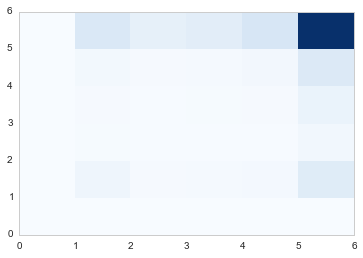

In [31]:
print(cf)
plt.pcolor(cf, cmap=plt.cm.Blues)
print(np.sum(cf, axis=0))
print(np.sum(cf, axis=1))

In [32]:
columnsused = all_x.columns
featimportance = rfc.feature_importances_

print("list of features and importance for model overall:\n\n")
for x in np.argsort(featimportance)[::-1]:
    print("feature: ", columnsused[x], "\nimportance: ", featimportance[x], "\n")

list of features and importance for model overall:


feature:  length_comment 
importance:  0.534002040414 

feature:  etadays 
importance:  0.213668060524 

feature:  dbio_verid 
importance:  0.107401350338 

feature:  sentiment 
importance:  0.0760768197957 

feature:  ccare_required 
importance:  0.0122596264232 

feature:  late 
importance:  0.0109837003546 

feature:  FXSP 
importance:  0.0105157141154 

feature:  Not yet delivered 
importance:  0.00889201452973 

feature:  FDEG 
importance:  0.00872812917103 

feature:  ontime 
importance:  0.00853326551147 

feature:  early 
importance:  0.00560178845314 

feature:  FX 
importance:  0.00333749036949 



### feature importance show's:
- that a longer comment (more things complained about probably, i.e. find common issues with some easy NLP stuff in long_comment and fix them) and being slow are big factors in customer having poor overall experience
- shipping types not very important to overall score prediction which could mean multiple things (i.e. shipper not at fault for poor experience)

###final remarks
going off of this, 
error of expected delivery versus date delivered seem's to be important.  Accuracy of the model is not "great" but seem's precise.  